In [14]:
import numpy as np
np.random.seed(1000)
import cv2
import os
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

os.environ['KERAS_BACKEND'] = 'tensorflow'

In [19]:
image_directory = 'cell_images/'
SIZE = 64
dataset = []
label = []

parasitized_images = os.listdir(image_directory + 'Parasitized/')
for i, image_name in enumerate(parasitized_images):
    if(image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Parasitized/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(0)
        


In [20]:
uninfected_images = os.listdir(image_directory + 'Uninfected/')
for i, image_name in enumerate(uninfected_images):
    if(image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Uninfected/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        label.append(1)
        


In [13]:
INPUT_SHAPE = (SIZE,SIZE,3)
inp = keras.layers.Input(shape = INPUT_SHAPE)

conv1 = keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same')(inp)
pool1 = keras.layers.MaxPooling2D(pool_size = (2,2))(conv1)
norm1 = keras.layers.BatchNormalization(axis = -1)(pool1)
drop1 = keras.layers.Dropout(rate=0.2)(norm1)

conv2 = keras.layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same')(drop1)
pool2 = keras.layers.MaxPooling2D(pool_size = (2,2))(conv2)
norm2 = keras.layers.BatchNormalization(axis = -1)(pool2)
drop2 = keras.layers.Dropout(rate=0.2)(norm2)

flat = keras.layers.Flatten()(drop2)

hidden1 = keras.layers.Dense(512, activation='relu')(flat)
norm3 = keras.layers.BatchNormalization(axis = -1)(hidden1)
drop3 = keras.layers.Dropout(rate=0.2)(norm3)

hidden2 = keras.layers.Dense(512, activation = 'relu')(drop3)
norm4 = keras.layers.BatchNormalization(axis = -1)(hidden2)
drop4 = keras.layers.Dropout(rate=0.2)(norm4)

out = keras.layers.Dense(2, activation = 'sigmoid')(drop4)

model = keras.Model(inputs = inp, outputs = out)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(model.summary())


Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)       

In [21]:
X_train, X_test, y_train, y_test = train_test_split(dataset, to_categorical(np.array(label)), test_size = 0.2, random_state = 0)

history = model.fit(np.array(X_train), y_train, batch_size = 64, verbose = 1, epochs = 5, validation_split = 0.1, shuffle = False)



Epoch 1/5
311/311 [==============================] - 71s 229ms/step - loss: 0.5672 - accuracy: 0.7338 - val_loss: 0.8993 - val_accuracy: 0.7184
Epoch 2/5
311/311 [==============================] - 73s 233ms/step - loss: 0.2433 - accuracy: 0.9093 - val_loss: 0.6294 - val_accuracy: 0.8168
Epoch 3/5
311/311 [==============================] - 72s 232ms/step - loss: 0.1923 - accuracy: 0.9289 - val_loss: 0.2904 - val_accuracy: 0.8798
Epoch 4/5
311/311 [==============================] - 72s 232ms/step - loss: 0.1714 - accuracy: 0.9362 - val_loss: 0.1637 - val_accuracy: 0.9474
Epoch 5/5
311/311 [==============================] - 72s 232ms/step - loss: 0.1488 - accuracy: 0.9437 - val_loss: 0.1797 - val_accuracy: 0.9356


173/173 [==============================] - 5s 27ms/step - loss: 0.1898 - accuracy: 0.9325
Test Accuracy: 93.25


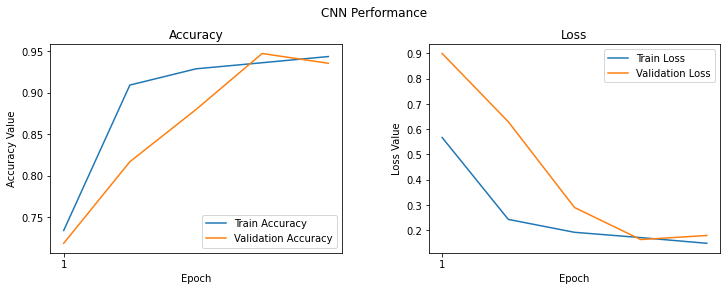

In [22]:
print("Test Accuracy: {:.2f}".format(model.evaluate(np.array(X_test), np.array(y_test))[1]*100))

import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
t = f.suptitle('CNN Performance', fontsize = 12)
f.subplots_adjust(top = 0.85, wspace = 0.3)

max_epoch = len(history.history['accuracy']) + 1
epoch_list = list(range(1, max_epoch))

ax1.plot(epoch_list, history.history['accuracy'], label = 'Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = 'best')

ax2.plot(epoch_list, history.history['loss'], label = 'Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = 'best')

model.save('malaria_classifier.h5')
